A Toy Oxford Nanopore Simulator Using A Hierarchical Bayesian Model in PyMC3
============================================================================

Oxford Nanopore (ONT) sells an inexpensive sequencer called the [MinION](https://www.nanoporetech.com/).
It's an unusual device in that the sequencing "flowcells" use protein pores that are fragile and unpredictable. 
As you might expect if you're familiar with proteins, they are sensitive to their environment (especially heat) 
and can get damaged or degraded and stop working.

When you receive a flowcell from ONT, only a fraction of the possible 2048 pores work, maybe about 700–1200. 
Because of how the flowcell works, you generally start a run with zero or one pores from each of 512 "channels" (each of which contains 4 pores).

As DNA passes through the pores, they can get gummed up and stop working.
It's not unusual to start a run with 400 pores and end a few hours later with 
half that many still active.
It's also not unusual to put a flowcell in the fridge and when you take it out it has
20% fewer pores. 
(Conversely, pores can come back to life after a bit of a rest.)
My point is, pores are moody and probabilistic.

Together, this means it's quite difficult to tell how much sequence you can expect from a run. If you want to sequence a plasmid at 100X, and you are starting with 400 pores, will you get enough data in two hours? That's the kind of question we want an answer to.

In [758]:
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as T

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from functools import partial

For testing purposes — and because I don't have nearly enough real data — I will simulate some data.

In this toy example, DNA of length 1000+/-50 bases is sequenced for 1000, 20000 or 40000 seconds at 250bp/s.
After 100 reads, a pore gets blocked and can no longer sequence. 
The device I am simulating has only 3 pores (where a real MinION would have 512).

In [757]:
datatypes = [
    ('total_num_reads', np.int),        ('total_dna_read', np.int),
    ('num_minutes', np.float),
    ('num_active_pores_start', np.int), ('num_active_pores_end', np.int),
    ('mean_input_dna_len_estimate', np.float)]

# Currently:
# - read all DNA loaded (no dna breaking model)
# - one pore only that gets used up during the run
#
MAX_PORES = 3
AXIS_RUNS, AXIS_PORES = 0, 1

data2 = np.array([
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 200, 200,  1000.0,    1,    0,  1.0),
  ( 300, 300,  1000.0,    1,    0,  1.0),
  ( 400, 400,  1000.0,    1,    0,  1.0),
  ( 400, 400,  1000.0,    1,    0,  1.0),
], dtype=datatypes)

# 4 seconds to read, 96 seconds to capture
# 10 reads per 1000 seconds
data = np.array([
  ( MAX_PORES*9,   MAX_PORES*  9*1000*.95,    1000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
  ( MAX_PORES*10,  MAX_PORES* 10*1000*1.05,   1000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
  ( MAX_PORES*10,  MAX_PORES* 10*1000*.95,    1000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
  ( MAX_PORES*11,  MAX_PORES* 11*1000*1.05,   1000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
  ( MAX_PORES*100, MAX_PORES*100*1000*.95,   20000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
  ( MAX_PORES*100, MAX_PORES*100*1000*1.05,  20000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
  ( MAX_PORES*100, MAX_PORES*100*1000*.95,   40000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
  ( MAX_PORES*100, MAX_PORES*100*1000*1.05,  40000.0/60,  MAX_PORES,  MAX_PORES,  1000.0),
], dtype=datatypes)

# data = np.array([
#   (  52,  2000*52,     60.0,    1,    1,  2000.0),
#   (  52,  2000*52,     60.0,    1,    1,  2000.0),
#   (  47,  4000*47,     60.0,    1,    1,  4000.0),
#   (  94,  4000*94,    120.0,    1,    1,  4000.0),

#   ( 100, 4000*100,    240.0,    1,    0,  4000.0),
#   ( 150, 4000*150,    240.0,    1,    0,  4000.0),
#   (  75,  4000*75,    240.0,    1,    0,  4000.0),
#   ( 175, 4000*175,    240.0,    1,    0,  4000.0),
#   ( 175, 4000*175,    480.0,    1,    0,  4000.0),
# ], dtype=datatypes)

#data = np.array([
#   (  44,    69501,     60.0,    1,    1,  2000.0),
#   (  36,   275440,     60.0,    1,    1,  8000.0),
#   (  51,   127152,     60.0,    1,    1,  3000.0),
#   (  59,   161172,     60.0,    1,    1,  3000.0),
#   (  75,   582726,    120.0,    1,    1,  8000.0),
#   ( 134,   938406,    180.0,    1,    1,  8000.0),
#   ( 156,   312548,    180.0,    1,    1,  2000.0),
#   ( 167,   334427,    300.0,    1,    0,  2000.0),
#   ( 316,   587468,    600.0,    1,    0,  2000.0),
#   ( 344,  1046926,    600.0,    1,    0,  3000.0),
#   ( 470,  1534980,    600.0,    1,    1,  3000.0),
#   ( 319,   643649,   3000.0,    1,    0,  2000.0),
#   ( 285,   862323,   3000.0,    1,    0,  3000.0),
#   ( 932,  2851522,   3000.0,    1,    0,  3000.0),
#   (1107,  2215908,   3000.0,    1,    0,  2000.0),
#   (1134,  3361498,   3000.0,    1,    0,  3000.0),
#   (2044,  6054852,   3000.0,    1,    0,  3000.0),
#   (2051,  4024988,   3000.0,    1,    0,  2000.0),
#   (2195, 10884337,   3000.0,    1,    1,  5000.0),
#], dtype=datatypes)

fulldata = np.copy(data)

Tests
-----
Various tests of how PyMC3 works...

In [732]:
def test_Lognormal():
    """How does the Lognormal tau parameter map onto sd?"""
    nd = np.random.normal(loc=1000, scale=10, size=1000)
    print(np.mean(nd), np.std(nd))
    shape0,loc0,scale0 = st.lognorm.fit(nd, 1, floc=0)
    print(shape0, loc0, scale0)

    with pm.Model() as model:
        sd = 10
        input_dna_len = pm.Lognormal('test', mu=np.log(100000), tau=1)
        gam = pm.Gamma('gam', 10, 10)
        start = pm.find_MAP()
        print("start", start)
        step = pm.Metropolis()
        trace = pm.sample(1000, step, start=start)
        print(np.mean(trace['test']), np.std(trace['test']))
        print(np.mean(trace['gam']), np.std(trace['gam']))
        print(shape0, loc0, scale0, np.log(1000), 100)


def test_DensityDist():
    """How to use DensityDist to enforce a constraint"""
    import scipy.stats as sp
    from functools import partial

    def apply_mul_constraint(f1, f2, observed):
        # pm.log = <T.elemwise.Elemwise>
        diff = T.sub(T.mul(f1, f2), observed)
        # This works up to a point
        # like = -pm.log(T.sqr(diff))
        # This "normal" version just fails?
        # like = pm.log(T.exp(T.neg(T.sqr(diff))))
        # This is the most robust way to do it, allowing for unlikely f1/f2?
        like = -T.abs_(diff)

        print("values", len(list(observed)), observed, like)
        return like

    with pm.Model() as model:
        dd_data = np.repeat(1000,5) #np.random.normal(loc=250, scale=10, size=10)
        norm1 = pm.Normal('norm1', mu=10, sd=1)
        norm2 = pm.Normal('norm2', mu=20, sd=2)

        norm_constraint = partial(apply_mul_constraint, norm1, norm2)
        constraint = pm.DensityDist('constraint', norm_constraint, observed=dd_data)

        step = pm.Metropolis() # or NUTS
        trace = pm.sample(1000, step)
        print("mean", len(trace['norm1']), np.mean(trace['norm1']),
            len(trace['norm2']), np.mean(trace['norm2']))
        print(trace['norm1'][10:15], trace['norm1'][-5:])
        print(trace['norm2'][10:15], trace['norm2'][-5:])
        print(trace['norm1'][-1] * trace['norm2'][-1])

        f = plt.figure()
        ax = pm.traceplot(trace[-1000:],
                          figsize=(12,len(trace.varnames)*1.5),
                          lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

        plt.savefig("temp.png")

def test_normal():
    dd = np.random.normal(100, 10, size=1000)
    with pm.Model() as model:
        test_mu = pm.Flat('flat_mu', testval=100)
        test_sd = pm.Lognormal('flat_sd', mu=10, tau=1)
        normal = pm.Normal('normal', mu=test_mu, sd=test_sd)
        dens = pm.DensityDist('dd', lambda obs: -T.abs_(normal-obs), observed=dd)
        trace = pm.sample(10000, pm.Metropolis(), njobs=1)
        print("\n",pm.df_summary(trace[-N//2:]))

def test_constraint():
    def apply_constraint(Tf, f1, f2, observed):
        b = 1 # https://pymc-devs.github.io/pymc3/api.html#pymc3.distributions.continuous.Laplace
        nrm = 1/(2.*b)
        return T.log(T.mul(nrm, T.exp(T.neg(T.true_div(T.abs_(T.sub(Tf(f1,f2), observed)), b)))))

    # Model: 10 bases per second up to a limit of 100 bases
    n = 100
    times = np.arange(1,n+1)
    d1 = 10 * times
    d2 = np.random.poisson(100, size=d1.shape)
    dd = np.choose( d1>d2, [d1, d2])
    print(sorted(dd))
    
    with pm.Model() as model:
        _num_no_block = 10 #pm.Poisson("num_no_block", mu=10)
        num_nb_total = pm.Deterministic('num_nb_total', T.mul(_num_no_block, times))

        test_mu = pm.Flat('test_mu', testval=100)
        num_wi_block = pm.Poisson('num_wi_block', mu=test_mu) # should be 100
        min_con = partial(apply_constraint, T.minimum, num_nb_total, num_wi_block)
        total = pm.DensityDist('total', min_con, observed=dd)
        trace = pm.sample(10000, pm.Metropolis(), njobs=1)
        print("\n",pm.df_summary(trace[-N//2:], varnames=[v for v in trace.varnames if not 'num_nb_total' in v]))
        pm.traceplot(trace[-1000:])

def test_theano():
    a = T.constant([1,2,3])
    b = T.constant([0,1,4])
    c = T.sum(T.switch(T.lt(a,b), 0, 1))
    print(a,b)
    print(c.eval())
    
def test_simple_constraint():
    data = np.random.normal(loc=10,size=100) + np.random.normal(loc=1,size=100)
    with pm.Model() as model:
        x = pm.Normal("x", mu=0, sd=10)
        y = pm.Normal("y", mu=0, sd=1)
        #z = pm.Deterministic(x + y, observed=data)
        z = pm.Laplace('x+y', mu=x+y, b=.1, observed=data)
        trace = pm.sample(1000, pm.Metropolis())
        print("\n",pm.df_summary(trace))
        #test_Lognormal()

#test_DensityDist()
#test_constraint()
#test_normal()
#test_theano()
#test_simple_constraint()

Simulator
---------
I made an ONT simulator as a jupyter notebook. The model is simple: a pore reads DNA until it's all read, then afterward with low probability it gets blocked and can no longer sequence. I've been fiddling with the parameters to give a reasonable result for our runs, but we don't have too much data yet, so it's not terribly accurate. (The model itself may also be inaccurate, since *how* the pore gets gummed up is not really discussed by ONT.)

Nevertheless, the simulator has been a useful tool for helping us decide how long to let our sequencer go for. I then turned the notebook into an app using dappled, an awesome new service built on AWS lambda.

Hierarchical Bayesian model
===========================
Here's where things get complicated and frankly a bit impractical, but interesting...

In theory, given some data from nanopore runs, we should be able to learn the parameters for a model that would enable us to predict how much data we would get from a new nanopore run.
Like many problems, this is a good fit for Bayesian analysis, since we want to estimate a model given some data.

For each run, I need to know:
- what length DNA I think I started with
- how long the run was in minutes
- how many reads I get
- how much sequence I get
- the number of pores at the start and the end of a run

I'll use PyMC3 for this problem. First, I need to specify some priors. 

Input DNA
---------
The input DNA depends a lot on the preparation.
I believe the distribution of input DNA lengths could be 
- exponential if it were genomic DNA breaking randomly
- normalish with a small variance if it were from a plasmid,
- normalish but sharply truncated if it were cut out of a gel.

Technically, the length of input DNA is different to the length of DNA sequenced by the sequencer, 
which is subject to breakage and unfinished sequencing (say, breakage during sequencing).

We can get arbitrarily complex here. 
For example, we could include a mixture model for different DNA types (genomic vs plasmid)
that could be learned from the data.
A simple distribution with small variance but fat tails seems conservative to me.
I'll model the `mean_input_dna_len` as a T distribution. I don't have much idea what the standard deviation should be, so I'll make it a fraction of the mean.

In [746]:
with pm.Model() as model:
    mean_input_dna_len = pm.StudentT('mean_input_dna_len', nu=3, mu=data['mean_input_dna_len_estimate'], 
                                     sd=data['mean_input_dna_len_estimate']/5, shape=data.shape)

INFO (theano.gof.compilelock): Refreshing lock /Users/briann/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


Some notes on what's going on:
- `shape=data.shape` means that there are `len(data)` separate estimations of `mean_input_dna_len`,
one for each run.
- Absent better ideas, I'll generally be using a T distribution instead of a normal, as MacKay recommends (Information Theory p312). This distribution should be truncated at zero, but I can't do this for multidimensional data because of what I think is a bug in pymc3.
- I am not modeling the `input_dna_len` here, just the mean of that distribution. 
As I mention above, the distribution of DNA lengths could be modeled several ways, but I only need the mean in my model. 

R9 read speed
-------------
I know that the R9 pore is supposed to read at 250 bases per second.
I believe the mean could be a little bit more or less than that, 
and I believe that all flowcells and devices should be about the same speed, 
therefore all runs will sample from the same distribution of `mean_read_speed`.
(A more general version would have a prior on `mu` and allow different runs to have different `mu`s.)

In [747]:
Truncated0T1D = pm.Bound(pm.StudentT, lower=0)
with pm.Model() as model:
    mean_read_speed = Truncated0T1D('mean_read_speed', nu=3, mu=250, sd=10, shape=data.shape)

Applied lowerbound-transform to mean_read_speed and added transformed mean_read_speed_lowerbound_ to model.


Capturing DNA
-------------
DNA is flopping around in solution, randomly entering pores now and then.
How long will a pore have to wait for DNA?
I have a vague idea that it should take around 60 seconds but this is an unknown that the 
sampler should figure out. 

Note again that this is the mean time, not the distribution of times!
The actual distribution of times to capture DNA would likely be distributed by an exponential distribution.

Notice that there is a hierarchy here: each run can have a mean drawn from a different distribution, since they can have different concentrations of DNA.

In [739]:
with pm.Model() as model:
    prior_mean_time_to_capture_dna = Truncated0T1D('prior_mean_time_to_capture_dna', nu=3, mu=60, sd=30)
    mean_time_to_capture_dna = pm.StudentT('mean_time_to_capture_dna', nu=3, mu=prior_mean_time_to_capture_dna, 
                                           sd=prior_mean_time_to_capture_dna/10, shape=data.shape)

Applied lowerbound-transform to prior_mean_time_to_capture_dna and added transformed prior_mean_time_to_capture_dna_lowerbound_ to model.
Applied lowerbound-transform to mean_time_to_capture_dna and added transformed mean_time_to_capture_dna_lowerbound_ to model.


Reading DNA
-----------
I can use pymc3's Deterministic type to calculate how long a pore spends reading a chunk of DNA, on average. 
That's just a division, but note it uses theano's `true_div` function instead of 
a regular division. This is because neither value is a number, they are random variables.
Theano will calculate this as it's being sampled.
(A `/` works here too, but I like to keep in mind what's being done by theano if possible.)

In [741]:
with pm.Model() as model:
    mean_time_to_read_dna = pm.Deterministic('mean_time_to_read_dna', T.true_div(mean_input_dna_len, mean_read_speed))

Then each pore can do how many reads in this run?
Sometimes it's clear, but here I have to be a bit careful to specify that I mean the number of reads possible per pore.

In [742]:
with pm.Model() as model:
    num_reads_possible_in_time_per_pore = pm.Deterministic('num_reads_possible_in_time_per_pore',
        T.true_div(num_seconds_run, T.add(mean_time_to_capture_dna, mean_time_to_read_dna)))

Blocking pores
--------------
In my model, after each read ends, a pore can get blocked, and once it's blocked it does not
become unblocked.
I believe about one in a hundred times, a pore will be blocked after if finishes sequencing DNA.
If it were more than that, sequencing would be difficult, but it could be much less.

In [760]:
with pm.Model() as model:
    prior_p_pore_blocked_a, prior_p_pore_blocked_b, = 1, 99
    p_pore_blocked = pm.Beta('p_pore_blocked', alpha=prior_p_pore_blocked_a, beta=prior_p_pore_blocked_b)

Applied logodds-transform to p_pore_blocked and added transformed p_pore_blocked_logodds_ to model.


Then, per pore, the number of reads before blockage is distributed as an exponential 
based on this probability.
Here my `shape` is the number of runs (rows) x number of pores (columns) since here
I need to model each pore separately.

In [761]:
with pm.Model() as model:
    num_reads_before_blockage = pm.Exponential('num_reads_before_blockage', lam=p_pore_blocked, 
        shape=(data.shape[0], MAX_PORES))

Applied log-transform to num_reads_before_blockage and added transformed num_reads_before_blockage_log_ to model.


Constraints
-----------

Here things get a little more complicated. 
In PyMC3, it is not possible to have two random variables x and y,
set x + y = data and sample values of x and y.
This is something you might think comes up all the time though...

In [750]:
testdata = np.random.normal(loc=10,size=100) + np.random.normal(loc=1,size=100)
with pm.Model() as testmodel:
    x = pm.Normal("x", mu=0, sd=10)
    y = pm.Normal("y", mu=0, sd=1)
    # This does not work
    #z = pm.Deterministic(x + y, observed=data)
    # This does work
    z = pm.Normal('x+y', mu=x+y, sd=1, observed=testdata)
    trace = pm.sample(1000, pm.Metropolis())

INFO (theano.gof.compilelock): Refreshing lock /Users/briann/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


 [-----------------100%-----------------] 1000 of 1000 complete in 0.3 sec

So it's more like a regression where you minimize error than a true constraint.
The smaller the standard deviation, the more you penalize errors.
However, you need some slack so that it's possible for the model to fit the data.
If the standard deviation goes too low, you end up with numerical problems (e.g., `nan`s).
Unfortunately, I do not know of a reasonable way to set this value.

I encode constraints in my model in a similar way:

First I define a Laplace distribution in theano to act as my likelihood.
Why Laplace instead of Normal? 
In practice it seemed to work a bit better.

Using your own DensityDist allows you to use any function as a likelihood.
I use DensityDist just to have more control over the likelihood,
and to differentiate from a true Normal/Laplacian distribution.
The samplers can be very finicky, so I've had to spend a bunch of time tweaking this. 

In [748]:
def T_Laplace(val, obs, b=1):
    return T.log(T.mul(1/(2*b), T.exp(T.neg(T.true_div(T.abs_(T.sub(val, obs)), b)))))

Constraint #1
-------------
The total DNA I have read must be the product of mean_input_dna_len and total_num_reads.
`mean_input_dna_len` can be different to my estimate.

This is a bit redundant since I know `total_num_reads` and `total_dna_read` exactly.
In a slightly more complex model we would have a parameter modeling the fraction of input DNA successfully sequenced.
Here we are just calculating `mean_input_dna_len` as `total_dna_read / total_num_reads`.

In [752]:
def apply_mul_constraint(f1, f2, observed):
    b = 1 # 1 fails with NUTS (logp=-inf), 10/100 fails with NUTS too (not positive definite)
    return T_Laplace(T.mul(f1,f2), observed, b)

with pm.Model() as model:
    total_dna_read_constraint = partial(apply_mul_constraint, mean_input_dna_len, data['total_num_reads'])
    constrain_total_dna_read = pm.DensityDist('constrain_total_dna_read', total_dna_read_constraint, observed=data['total_dna_read'])

Constraint #2
-------------
The number of reads per pore is whichever is lower:
- the number of reads the pore could manage in the length of the run 
- the number of reads before getting blocked

To encode this, I compare, per pore, `num_reads_before_blockage` and `num_reads_possible_in_time_per_pore`.

First, I use `T.tile` to replicate `num_reads_possible_in_time_per_pore` for all pores.
That turns it from an array of length #runs to a matrix of shape #runs x #pores.

Then I take the minimum value of these two arrays (`T.lt`) and if the minimum 
value is the number of reads before blockage (`T.switch(T.lt(f1,f2),0,1)`) then that pore is blocked, otherwise it is active. 
I sum these 0/1s over all pores (`axis=AXIS_PORES`) to get a count of the number of active pores for each run.

The value of this count is constrained to be equal to `data['num_active_pores_end']`.

In [756]:
def apply_count_constraint(num_reads_before_blockage, num_reads_possible_in_time_broadcast, observed):
    b = 1
    num_active_pores = T.sum(T.switch(T.lt(num_reads_before_blockage, num_reads_possible_in_time_broadcast),0,1),axis=AXIS_PORES) 
    return T_Laplace(num_active_pores, observed, b)

with pm.Model() as model:
    num_reads_possible_in_time_broadcast = T.tile(num_reads_possible_in_time_per_pore, (MAX_PORES,1)).T
    num_active_pores_end_constraint = partial(apply_count_constraint, num_reads_before_blockage, num_reads_possible_in_time_broadcast)
    constrain_num_active_pores_end = pm.DensityDist('constrain_num_active_pores_end', num_active_pores_end_constraint, observed=data['num_active_pores_end'])

Constraint #3
-------------
This is similar to constraint #2.
Using the same matrix `num_reads_possible_in_time_broadcast`
this time I sum the total number of reads from each pore in a run.
I simply take the minimum value from each pore: 
either the number before blockage occurs or the total number possible. 

In [762]:
def apply_minsum_constraint(num_reads_before_blockage, num_reads_possible_in_time_broadcast, observed):
    b = 1 # b=1 fails with ADVI and >100 pores (nan)
    min_reads_per_run = T.sum(T.minimum(num_reads_before_blockage, num_reads_possible_in_time_broadcast),axis=AXIS_PORES)
    return T_Laplace(min_reads_per_run, observed, b)

with pm.Model() as model:
    total_num_reads_constraint = partial(apply_minsum_constraint, num_reads_before_blockage, num_reads_possible_in_time_broadcast)
    constrain_total_num_reads = pm.DensityDist('constrain_total_num_reads', total_num_reads_constraint, observed=data['total_num_reads'])

Sampling
========
There are three principal ways to sample in PyMC3:
- **Metropolis-Hastings**: the simplest sampler, generally works fine on simpler problems
- **NUTS**: more efficient than Metropolis, but I've found it to be slow and tricky to get to work
- **ADVI**: the new, fast way to estimate a posterior. This seems to work great, though
it requires continuous distributions only (no Geometric, for example)

I used ADVI most of the time in this project, since NUTS was way too slow and the results seemed more sensible than Metropolis.

Results
-------

In my toy model, it takes 4 seconds to sequence a DNA molecule (~1000 bases / 250 bases per second)
and 96 seconds to capture a DNA molecule.

Here are the number of reads possible compared to the number of reads before blockage.
According to my sampler, runs 4,5,6,7 have pores blocked, as I expect.

I expect 1 read per pore per 100 seconds (making 10, 200, and 400 reads possible).
I expect each pore to get blocked after 100 reads (and remember there are 3 pores).

Finally, I expect 3 pores remaining in the first four runs, and 0 pores remaining in the last four.

    mean_input_dna_len__0                    950.0
    mean_input_dna_len__1                   1050.0
    mean_input_dna_len__2                    950.0
    mean_input_dna_len__3                   1050.0
    mean_input_dna_len__4                    950.0
    mean_input_dna_len__5                   1049.9
    mean_input_dna_len__6                    950.0
    num_reads_possible_in_time_per_pore__0    10.1  
    num_reads_possible_in_time_per_pore__1    10.3  
    num_reads_possible_in_time_per_pore__2    10.2  
    num_reads_possible_in_time_per_pore__3    10.5  
    num_reads_possible_in_time_per_pore__4   210.9  
    num_reads_possible_in_time_per_pore__5   207.4  
    num_reads_possible_in_time_per_pore__6   419.8  
    num_reads_possible_in_time_per_pore__7   413.2
    num_reads_before_blockage_per_run__0     501.3  557.3  
    num_reads_before_blockage_per_run__1     509.8  543.0  
    num_reads_before_blockage_per_run__2     501.9  512.4  
    num_reads_before_blockage_per_run__3     502.4  591.5  
    num_reads_before_blockage_per_run__4     297.2   39.0  
    num_reads_before_blockage_per_run__5     298.7   38.7  
    num_reads_before_blockage_per_run__6     299.6   38.6  
    num_reads_before_blockage_per_run__7     301.2   38.3  
    num_active_pores_per_run__0                2.8   
    num_active_pores_per_run__1                2.8   
    num_active_pores_per_run__2                2.8   
    num_active_pores_per_run__3                2.8   
    num_active_pores_per_run__4                0.0   
    num_active_pores_per_run__5                0.0   
    num_active_pores_per_run__6                0.0   
    num_active_pores_per_run__7                0.0 

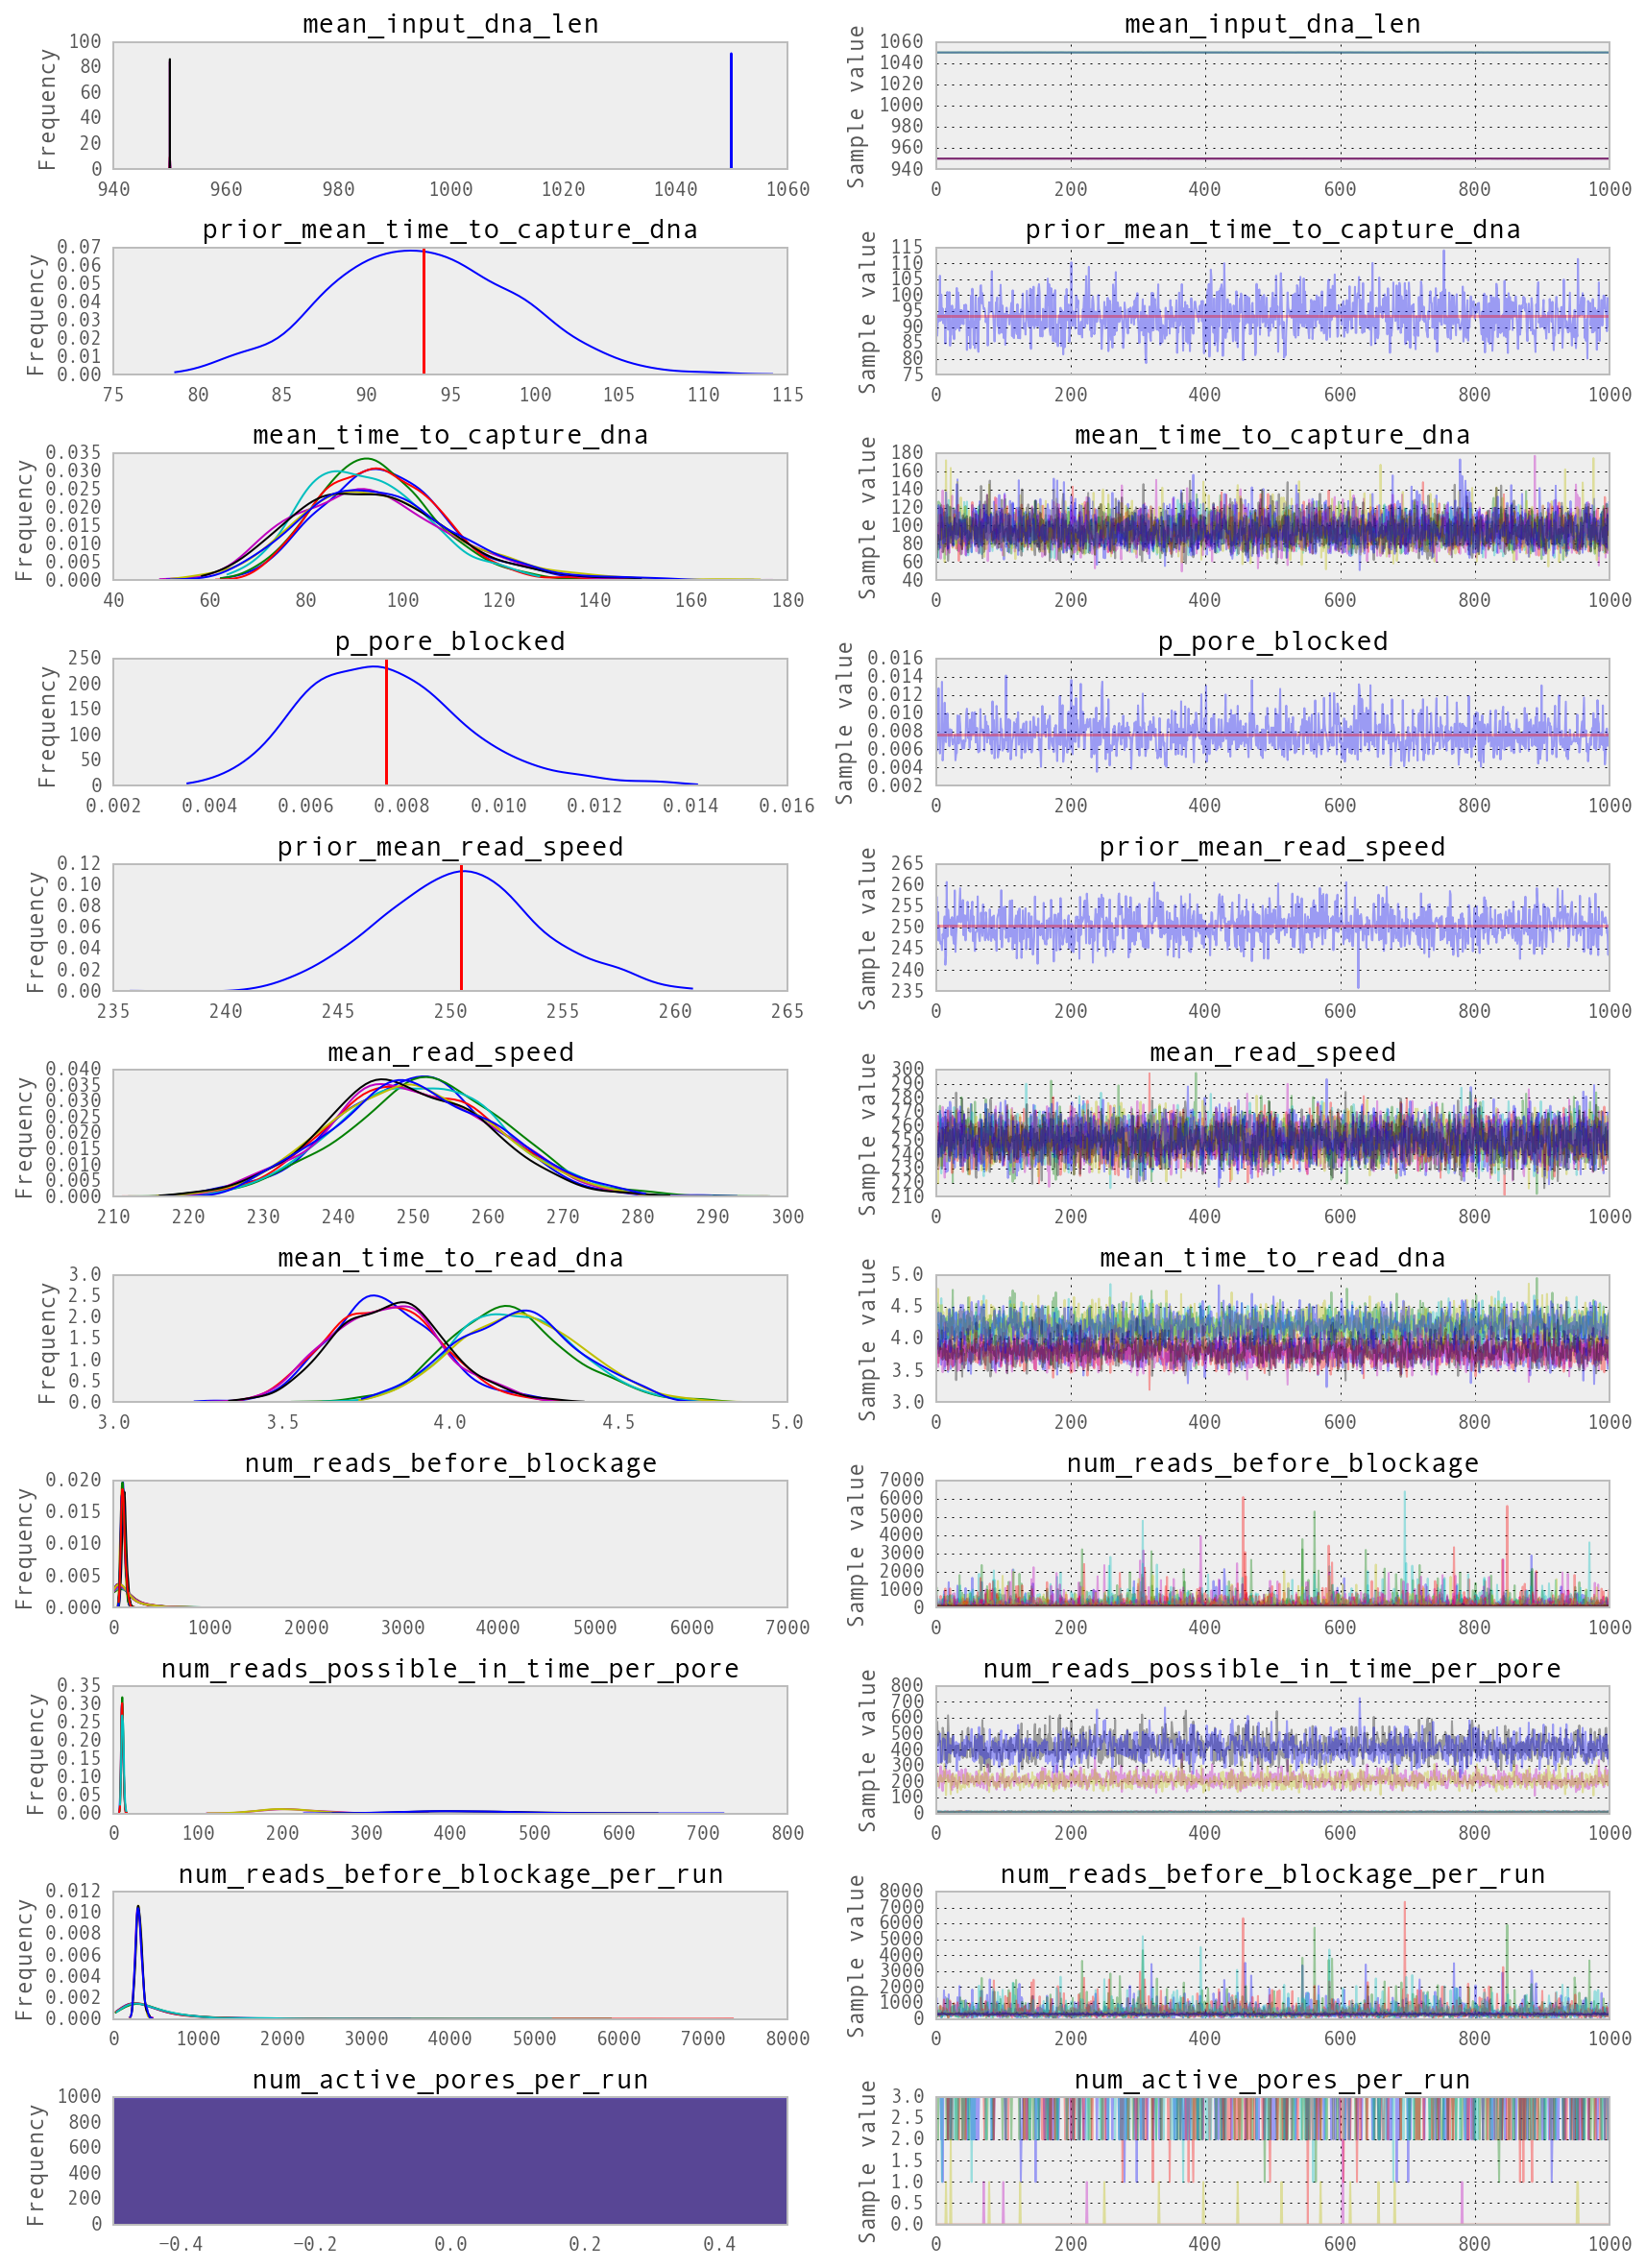

In [766]:
with pm.Model() as model:
    pm.traceplot(trace[-1000:], 
                 figsize=(12,len(trace.varnames)*1.5),
                 lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

Conclusions
-----------
Is this model actually useful? 
I think it's almost useful, but it suffers from a lack of robustness. 

The primary problem is that the results I get are sensitive to changes in several areas:
- the sampler
- the parameters for constraints
- the priors.
Changes in these parameters that I do not perceive as important can lead to very different results.

Another problem is that scaling this problem up to 512 pores is difficult numerically.
Metropolis fails, I think because it can't sample efficiently, NUTS fails for reasons I don't understand (throws an error), ADVI works best, but starts to get `nan`s as the number of pores grows, unless I loosen standard deviation of the constraints.

Finally, the model currently expects the same number of pores (MAX_PORES) to be available for every run.
I haven't addressed that yet, though I think it should be pretty straightforward. There may be an obvious trick I am overlooking.

In [765]:
#
# ADDENDUM
# Full model (excluding data)
#


def T_Laplace(val, observed, b=1):
    #b = 1 # 1 fails with NUTS (logp=-inf), 10/100 fails with NUTS too (not positive definite)
    return T.log(T.mul(1/(2*b), T.exp(T.neg(T.true_div(T.abs_(T.sub(val, observed)), b)))))

def apply_mul_constraint(f1, f2, observed):
    """Use the closest of f1 and f2 to the observed values as the likelihood.
    T.min and T.minimum are not the same!"""
    if True:
        return -T.abs_(T.sub(T.mul(f1, f2), observed))
    # Double exponential / Laplace
    b = 1 # 1 fails with NUTS (logp=-inf), 10/100 fails with NUTS too (not positive definite)
    return T_Laplace(T.mul(f1,f2), observed, b)

def apply_minsum_constraint(f1, f2, observed):
    """Use the closest of f1 and f2 to the observed values as the likelihood.
    T.min and T.minimum are not the same!"""
    if False:
        return -T.abs_(T.sub(T.minimum(f1, f2), observed))
    # Double exponential / Laplace
    b = 10 # =1 fails with ADVI (nan)
    min_reads_per_run = T.sum(T.minimum(f1,f2),axis=AXIS_PORES)
    return T_Laplace(min_reads_per_run, observed, b)

def apply_count_constraint(f1, f2, observed):
    b = 1 # https://pymc-devs.github.io/pymc3/api.html#pymc3.distributions.continuous.Laplace
    # count the number of times f2 >= f1, i.e., the number of times reads_possible exceeds reads_blocked
    # if reads_possible > reads_blocked then the pore is unblocked
    num_active_pores = T.sum(T.switch(T.lt(f1,f2),0,1),axis=AXIS_PORES) 
    return T_Laplace(num_active_pores, observed, b)


USE_ADVI = True
DOUBLE = True

if DOUBLE:
    data = np.copy(fulldata)
    data = data.repeat(1)
    print(data)

AXIS_RUNS, AXIS_PORES = 0, 1
print(data.shape)

with pm.Model() as model:
    #
    # Inputs to the model
    #

    num_seconds_run = data['num_minutes'] * 60
    num_active_pores_start = data['num_active_pores_start']
    mean_input_dna_len_estimate = data['mean_input_dna_len_estimate']

    #
    # Priors
    #
    
    # These do not work if shape is specified. Fixable if necessary.
    Truncated0Normal1D = pm.Bound(pm.Normal, lower=0)
    Truncated0T1D = pm.Bound(pm.StudentT, lower=0)

    # The input DNA should have a mostly known size distribution, different for each run, same for each pore.
    # StudentT, variance = 1/lam
    #prior_input_dna_len_tau = 10
    #input_dna_len = pm.Lognormal('input_dna_len', mu=np.log(mean_input_dna_len), tau=prior_input_dna_len_tau,
    #                             testval=np.log(mean_input_dna_len), shape=data.shape)
    mean_input_dna_len = pm.StudentT('mean_input_dna_len', nu=3, mu=mean_input_dna_len_estimate, 
                                     sd=mean_input_dna_len_estimate/4., shape=data.shape)
    
    # How long does one pore wait to capture a segment of DNA?
    # This is concentration-dependent. I assume concentration is almost the same for all experiments
    # "Exponential describes the time between events in a Poisson process"
    # http://www.wolframalpha.com/input/?i=exponential(rate%3D1%2F50.)
    prior_mean_time_to_capture_dna = Truncated0T1D('prior_mean_time_to_capture_dna', nu=3, mu=60, sd=30)
    
    # Real one
    #mean_time_to_capture_dna = pm.Exponential('mean_time_to_capture_dna', lam=1/prior_mean_time_to_capture_dna, shape=data.shape)
    mean_time_to_capture_dna = Truncated0T1D('mean_time_to_capture_dna', nu=3, mu=prior_mean_time_to_capture_dna, sd=prior_mean_time_to_capture_dna/8, shape=data.shape)
    # This test shows that the constraint is working (but Bound fails if time_to_capture_dna is not a scalar):
    #mean_time_to_capture_dna = pm.Bound(pm.Exponential, lower=50)('mean_time_to_capture_dna', lam=1/prior_mean_time_to_capture_dna)

    # after a read finishes pores should rarely be blocked
    # a prior of 1% seems reasonable
    prior_p_pore_blocked_a, prior_p_pore_blocked_b, = 1, 99
    p_pore_blocked = pm.Beta('p_pore_blocked', alpha=prior_p_pore_blocked_a, beta=prior_p_pore_blocked_b)


    # I expect read speed to be between 200 and 300 (2 SDs)
    # I assume read_speed is due to some property of the chip (voltage) and doesn't change over time
    prior_mean_read_speed = Truncated0Normal1D('prior_mean_read_speed', mu=250, sd=10)
    prior_sd_read_speed = 10
    mean_read_speed = Truncated0Normal1D('mean_read_speed', mu=prior_mean_read_speed, sd=prior_sd_read_speed, shape=data.shape)

    # The time to read DNA is easily calculated
    mean_time_to_read_dna = pm.Deterministic('mean_time_to_read_dna', mean_input_dna_len / mean_read_speed)


    # Per pore, how many reads can I do before getting blocked?
    # This obeys a geometric distribution
    # Or use pm.Geometric if I am not using ADVI # instead of lam, p (same value though)
    num_reads_before_blockage = pm.Exponential('num_reads_before_blockage', lam=p_pore_blocked, 
                                               shape=(data.shape[0], MAX_PORES))

    # Per pore: a read includes waiting for DNA, then sequencing it
    num_reads_possible_in_time_per_pore = pm.Deterministic('num_reads_possible_in_time_per_pore',
        T.true_div(num_seconds_run, T.add(mean_time_to_capture_dna, mean_time_to_read_dna)))

    # ------------------------------------------
    # Constraints
    #

    # You can read until you get blocked
    # Sum over all pores
    # num_reads_possible_in_time.T using dimshuffle((0,'x')) does not work
    # using _broadcast version gives the same results so broadcasting is working as expected
    
    # Reshape num_reads_possible_in_time to fit runs as rows and pores as columns
    num_reads_possible_in_time_broadcast = T.tile(num_reads_possible_in_time_per_pore, (MAX_PORES,1)).T
    
    total_num_reads_constraint = partial(apply_minsum_constraint,
                                         num_reads_before_blockage, num_reads_possible_in_time_broadcast)
    constrain_total_num_reads = pm.DensityDist('constrain_total_num_reads', total_num_reads_constraint, observed=data['total_num_reads'])
    
    
    # How many pores are left at the end? e.g., 480 -> 420
    # Sum over pores???
    # num_reads_possible_in_time is per pore
    
    # per_run is mainly for printing
    num_reads_before_blockage_per_run = pm.Deterministic('num_reads_before_blockage_per_run', T.sum(num_reads_before_blockage, axis=AXIS_PORES))

    # TEST
    num_active_pores_per_run = pm.Deterministic('num_active_pores_per_run', T.sum(T.switch(T.lt(num_reads_before_blockage,num_reads_possible_in_time_broadcast),0,1),axis=AXIS_PORES) )

    num_active_pores_end_constraint = partial(apply_count_constraint, 
                                              num_reads_before_blockage, num_reads_possible_in_time_broadcast)
    constrain_num_active_pores_end = pm.DensityDist('constrain_num_active_pores_end', num_active_pores_end_constraint, observed=data['num_active_pores_end'])
    
    
    # Total DNA read is simply input_dna_len * total_num_reads
    total_dna_read_constraint = partial(apply_mul_constraint, mean_input_dna_len, data['total_num_reads'])
    constrain_total_dna_read = pm.DensityDist('constrain_total_dna_read', total_dna_read_constraint, observed=data['total_dna_read'])
    
    
    # ----------------------------------------
    # Print and plot
    #
    # Then number of reads is the final output
    N = 10000

    if USE_ADVI:
        v_params = pm.variational.advi(n=500000, random_seed=1)
        trace = pm.variational.sample_vp(v_params, draws=N)
        #_start = trace[-1]
        #v_params = pm.variational.advi(n=5000, start=_start, random_seed=1)
    else:
        start = pm.find_MAP(fmin=sp.optimize.fmin_l_bfgs_b)
        print("start", start, model.logp(start))
        print("test_point", model.test_point)
        step = pm.NUTS(scaling=start)
        trace = pm.sample(N, step, njobs=1, random_seed=1)

    q = pm.quantiles(trace['p_pore_blocked'], [2.5, 5, 95, 97.5, 32, 68])
    val1 = np.random.exponential(1./q[2.5], size=10).mean()
    val2 = np.random.exponential(1./q[97.5], size=10).mean()
    valx = [np.random.exponential(1./t, size=1)[0] for t in trace['p_pore_blocked']]
    
    print("\nvals", val1, val2)
    print("valx", np.mean(valx), np.std(valx), "mean 1/p", np.mean(1./trace['p_pore_blocked']))
    
    if not USE_ADVI:
        print("\nstart:", model.logp(trace[50]))
        print("end:", np.mean([model.logp(trace[i]) for i in range(-100,0)]))
    print(pm.df_summary(trace[-N//2:]))


[(27, 25650, 16.666666666666668, 3, 3, 1000.0)
 (30, 31500, 16.666666666666668, 3, 3, 1000.0)
 (30, 28500, 16.666666666666668, 3, 3, 1000.0)
 (33, 34650, 16.666666666666668, 3, 3, 1000.0)
 (300, 285000, 333.3333333333333, 3, 3, 1000.0)
 (300, 315000, 333.3333333333333, 3, 3, 1000.0)
 (300, 285000, 666.6666666666666, 3, 3, 1000.0)
 (300, 315000, 666.6666666666666, 3, 3, 1000.0)]
(8,)
Applied lowerbound-transform to prior_mean_time_to_capture_dna and added transformed prior_mean_time_to_capture_dna_lowerbound_ to model.
Applied lowerbound-transform to mean_time_to_capture_dna and added transformed mean_time_to_capture_dna_lowerbound_ to model.
Applied logodds-transform to p_pore_blocked and added transformed p_pore_blocked_logodds_ to model.
Applied lowerbound-transform to prior_mean_read_speed and added transformed prior_mean_read_speed_lowerbound_ to model.
Applied lowerbound-transform to mean_read_speed and added transformed mean_read_speed_lowerbound_ to model.
Applied log-transform 

In [ ]:
with pm.Model() as model:
    # Plotting is very slow for some reason
    pm.traceplot(trace[-N//2:], 
                 #varnames=['time_to_capture_dna', 'p_pore_blocked', 'read_speed','num_reads_before_blockage'],
                 figsize=(12,len(trace.varnames)*1.5),
                 lines={k: v['mean'] for k, v in pm.df_summary(trace[-N//2:]).iterrows()})